# Methodology

 Here we want to extend the insights that Zeek and RITA are giving us about the probable sketchiness of particular connections. 
 
 While we're narrowing down things like beaconish traffic using statistical connection analysis, we can bring some local knowledge to add dimension. 
 
- Combine Beacons and Conns files to identify unique talkers
- retrieve BGP Autonomous Systems info to identify originators (or listeners) in Wild West zones
- Identify traffic from Insecure Countries

also - are we getting connections from nets that practice good hygiene? 
- is there a DNS entry?
- is there a PTR record

What local tools can add dimension?
- was the sender identified as malicious by fail2ban actions? (ICMP type 3 returns)

Open Blacklist entries:
- https://github.com/StevenBlack/hosts

In Addition - you may want to analyze office or home net traffic and find out chatty corporate tools. You can add your own, but this will add a score to tag "friendly surveillance" from Apple, Google, et al. My lists are US-Centric - tailor to your locale

This has some other helper tools, also. For example if you're publishing you may not desire to show off internal network specifics when publishing, so obscureIPs.py will reIP your local net/hosts to a range you specify (default 192.168.1.1).



In [3]:
# imports
import pandas as pd
import numpy as np

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Config matplotlib
%matplotlib inline
plt.rcParams["patch.force_edgecolor"] = True # in matplotlib, edge borders are turned off by default.
sns.set_style("darkgrid") # set a grey grid as a background

# turn off warnings
import warnings
warnings.filterwarnings('ignore')

import csv
import json
import datetime as datetime
import time

# ip/AS lookup tools
import socket
from ipwhois import IPWhois
from ipwhois.net import Net
from ipwhois.asn import IPASN

In [185]:
# define corporate target AS Descriptors
invasive_corps = ['AMAZON','APPLE','GOOGLE','MICROSOFT','CLOUDFLARENET','SALESFORCE','AKAMAI','OPENDNS']
sketchy_countries = ['CN','RU','VN','HK','TW','IN','BR','RO','HU','KR','IT','UG','TR','MY','BO','CO']


In [193]:
sketchy_providers = []
providers = open('beaconish_asns','r').readlines()
for p in providers:
    sketchy_providers.append(p.split()[0])

In [201]:
for p in providers:
    if 'US' in p:
        print(p)

 AS-SONICTELECOM, US

 CNNIC-ALIBABA-US-NET-AP Alibaba (US) Technology Co., Ltd., CN

 DIGITALOCEAN-ASN, US

 FASTLY, US

 LEVEL3, US

 LIGHTOWER, US

 LVLT-10753, US

 MICROSOFT-CORP-MSN-AS-BLOCK, US

 ORACLE-BMC-31898, US

 TWC-11427-TEXAS, US

 WNET, US



In [195]:
sketchy_providers[:5]

['AS-SONICTELECOM,', 'ASIANET', 'ASN-SPIN,', 'ASN-WINDTRE', 'BAIDU']

### load data

In [4]:
dfbeacons = pd.read_csv('2020-tank.beacons-scrubbed.csv')
dfconns = pd.read_csv('2020-tank.conns-scrubbed.csv')
#dfdns = pd.read_csv('dns.csv')

In [5]:
dfbeacons.head()

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion
0,0.870,71.212.150.232,10.4.86.55,47329,2170.0,300,14711272,15,574,27512,27324,0.0,0.0,0,0
1,0.861,174.21.76.74,10.4.86.55,35304,1348.0,299,3398356,15,522,26333,26070,0.0,0.0,0,0
2,0.845,52.84.150.39,10.4.86.55,14104,12.0,8532,48,1,0,3963,10575,0.0,0.0,0,0
3,0.840,10.4.86.55,71.212.150.232,14357,0.0,1113,0,300,0,1783,14357,0.0,0.0,1,0
4,0.838,10.4.86.55,174.21.76.74,12162,43.0,400,84,300,0,898,7092,0.0,0.0,1,0


In [6]:
dfconns.head()

,Source IP,Destination IP,Port:Protocol:Service,Duration
0,71.212.150.232,10.4.86.55,52456:tcp:- 52454:tcp:- 52452:tcp:- 37696:tcp:...,425655.0
1,174.21.76.74,10.4.86.55,50154:tcp:- 50150:tcp:- 35430:tcp:- 35428:tcp:...,169166.0
2,174.21.155.169,10.4.86.55,36022:tcp:- 36020:tcp:- 36018:tcp:- 36014:tcp:...,104601.0
3,10.4.86.55,112.85.42.102,3:icmp:-,81888.7
4,174.21.138.33,10.4.86.55,60398:tcp:- 60396:tcp:- 60394:tcp:- 53:tcp:dns...,50334.1


### merge 

In [7]:
dfconns['ConnString'] = dfconns['Source IP'] + '->' + dfconns['Destination IP']

In [8]:
dfbeacons['ConnString'] = dfbeacons['Source IP'] + '->'+ dfbeacons['Destination IP']

In [9]:
df = pd.merge(dfbeacons, dfconns, on=['ConnString'], how='inner')

### clean up merge data

since the merge key is an amagalm of connection to connection strings, the Source IP and Destination IP collision columns _x and _y should be erroneous.

**delete _ys and rename _x**

In [10]:
del df['Source IP_y']

In [11]:
del df['Destination IP_y']

In [12]:
df.rename(columns={"Destination IP_x": "Destination IP",'Source IP_x':'Source IP'}, inplace=True)

In [13]:
df.columns

Index(['Score', 'Source IP', 'Destination IP', 'Connections', 'Avg Bytes',
       'Intvl Range', 'Size Range', 'Top Intvl', 'Top Size', 'Top Intvl Count',
       'Top Size Count', 'Intvl Skew', 'Size Skew', 'Intvl Dispersion',
       'Size Dispersion', 'ConnString', 'Port:Protocol:Service', 'Duration'],
      dtype='object')

### adding hostname lookups

In [14]:
def iplookup(ipaddress):
    #print(ipaddress)
    try: 
        fullhostname = socket.gethostbyaddr(ipaddress)
        hostname = fullhostname[0]
    except Exception as e:
        hostname = ipaddress
    return hostname

In [15]:
df['Source Name'] = df['Source IP'].apply(iplookup)

In [16]:
# this takes awhile thanks to DNS timeouts
df['Destination Name'] = df['Destination IP'].apply(iplookup)

In [17]:
df.head()

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name
0,0.870,71.212.150.232,10.4.86.55,47329,2170.0,300,14711272,15,574,27512,27324,0.0,0.0,0,0,71.212.150.232->10.4.86.55,52456:tcp:- 52454:tcp:- 52452:tcp:- 37696:tcp:...,425655.000,71-212-150-232.tukw.qwest.net,mainhost
1,0.861,174.21.76.74,10.4.86.55,35304,1348.0,299,3398356,15,522,26333,26070,0.0,0.0,0,0,174.21.76.74->10.4.86.55,50154:tcp:- 50150:tcp:- 35430:tcp:- 35428:tcp:...,169166.000,174-21-76-74.tukw.qwest.net,mainhost
2,0.833,174.21.154.117,10.4.86.55,728,1571.0,7237,270414,15,522,620,604,0.0,0.0,0,0,174.21.154.117->10.4.86.55,22:tcp:- 9180:tcp:- 9119:tcp:- 9117:tcp:- 9100...,9300.070,174-21-154-117.tukw.qwest.net,mainhost
3,0.828,10.4.86.55,139.59.38.252,141,133.0,138,2120,65,88,30,138,0.0,0.0,1,0,10.4.86.55->139.59.38.252,3:icmp:-,133.375,mainhost,139.59.38.252
4,0.827,10.4.86.55,189.62.69.106,94,397.0,44573,1856,76,352,34,88,0.0,0.0,1,0,10.4.86.55->189.62.69.106,3:icmp:-,161.082,mainhost,bd3e456a.virtua.com.br


### Describing the IP sets

In [18]:
# unique localhosts
len(df['Source IP'].unique())

56

In [19]:
df['Source IP'].unique()

array(['71.212.150.232', '174.21.76.74', '174.21.154.117', '10.4.86.55',
       '193.112.19.133', '223.247.137.208', '222.186.42.7',
       '222.186.42.57', '222.186.42.213', '174.21.155.169',
       '123.206.65.38', '71.212.135.10', '118.89.245.202', '10.0.1.50',
       '106.52.152.237', '106.53.114.90', '122.51.22.134', '174.21.134.5',
       '49.233.32.245', '129.28.27.25', '122.194.229.59',
       '61.177.172.107', '61.177.172.128', '218.92.0.172', '85.209.0.102',
       '129.204.125.51', '117.211.192.70', '118.24.117.134',
       '166.78.71.156', '129.204.100.10', '49.232.191.178',
       '112.85.42.174', '94.191.62.195', '174.21.138.33',
       '194.180.224.130', '85.209.0.103', '189.62.69.106', '166.78.68.80',
       '139.186.68.53', '85.209.0.253', '122.51.221.184', '119.45.205.97',
       '85.209.0.251', '122.51.10.222', '119.45.137.52',
       '111.231.215.244', '49.232.162.77', '222.186.180.147',
       '102.37.12.59', '42.194.203.226', '159.135.232.78',
       '146.20.191.2

In [20]:
# unique targets
len(df['Destination IP'].unique())

662

In [21]:
# unique connections
len(df['ConnString'].unique())

715

### update AS info

feature engineering AS info

In [22]:
newcols = ['asn_registry', 'asn', 'asn_cidr', 'asn_country_code', 'asn_date', 'asn_description']

In [23]:
def getAsInfo(ipaddress, category='asn', **kwargs):
    """
    df['Destination IP'].apply(getAsInfoKwargs, category='asncidr',axis=1)
    """
    private = ['10.','172.','192.168.']
    if '10.4' in ipaddress:
        return 'rfc1918'
    #print(kwargs)
    net = Net(ipaddress)
    obj = IPASN(net)
    results = obj.lookup()
    if category is None:
        return "no category"
        #print(category)
    
    if category == 'reg':
        return results['asn_registry']
    elif category == 'asnnum':
        return results['asn']
    elif category == 'asncidr':
        return results['asn_cidr']
    elif category == 'asncc':
        return results['asn_country_code']
    elif category == 'asndate':
        return results['asn_date']
    elif category == 'asndesc':
        return results['asn_description']
    else:
        return False
    

#### add ASN columns

In [24]:
# add asncidr
df['asncidr'] = df['Destination IP'].apply(getAsInfo, category='asncidr',axis=1)

In [25]:
df['asn'] = df['Destination IP'].apply(getAsInfo, category='asnnum',axis=1)

In [26]:
df['asn_desc'] = df['Destination IP'].apply(getAsInfo, category='asndesc',axis=1)

In [27]:
df['asn_country'] = df['Destination IP'].apply(getAsInfo, category='asncc',axis=1)

In [203]:
df.head(3)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country,sketchy,has_ptr,src_ptr,dst_ptr
0,0.870,71.212.150.232,10.4.86.55,47329,2170.0,300,14711272,15,574,27512,...,71-212-150-232.tukw.qwest.net,mainhost,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True
1,0.861,174.21.76.74,10.4.86.55,35304,1348.0,299,3398356,15,522,26333,...,174-21-76-74.tukw.qwest.net,mainhost,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True
2,0.833,174.21.154.117,10.4.86.55,728,1571.0,7237,270414,15,522,620,...,174-21-154-117.tukw.qwest.net,mainhost,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True


**how many are unique?**

In [61]:
len(df['asn'].unique())

194

In [198]:
df['asn'].unique()[:10]

array(['rfc1918', '14061', '28573', '45090', '7713', '12880', '131367',
       '16276', '3462', '4812'], dtype=object)

In [199]:
len(df['asn_country'].unique())

51

In [81]:
df['asn_country'].unique()

array(['rfc1918', 'SG', 'BR', 'CN', 'ID', 'IR', 'VN', 'CA', 'US', 'TW',
       'IN', 'FR', 'AR', 'RU', 'CL', 'ES', 'EC', 'JP', 'FJ', 'SC', 'KR',
       'GB', 'MY', 'CO', 'UZ', 'JM', 'TR', 'MX', 'PH', 'PK', 'TH', 'ZA',
       'IT', 'HK', 'LA', 'BO', 'MU', 'CR', 'BD', 'MA', 'VE', 'BF', 'AE',
       'PY', 'UY', 'ZW', 'KZ', 'UG', 'HR', 'BG', 'LT'], dtype=object)

In [82]:
countries = df['asn_country'].unique()

In [196]:
df[df['asn_desc']!= 'rfc1918'][:5]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country,sketchy,has_ptr,src_ptr,dst_ptr
3,0.828,10.4.86.55,139.59.38.252,141,133.0,138,2120,65,88,30,...,mainhost,139.59.38.252,139.59.32.0/20,14061,"DIGITALOCEAN-ASN, US",SG,False,True,True,False
4,0.827,10.4.86.55,189.62.69.106,94,397.0,44573,1856,76,352,34,...,mainhost,bd3e456a.virtua.com.br,189.62.0.0/16,28573,"CLARO S.A., BR",BR,True,True,True,True
5,0.823,10.4.86.55,62.234.15.136,92,163.0,185,2224,89,88,13,...,mainhost,62.234.15.136,62.234.0.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,True,True,False
6,0.823,10.4.86.55,106.54.112.173,89,169.0,268,2472,87,88,15,...,mainhost,106.54.112.173,106.54.64.0/18,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN,True,True,True,False
7,0.823,10.4.86.55,139.59.70.186,77,167.0,156,2032,123,88,10,...,mainhost,139.59.70.186,139.59.64.0/20,14061,"DIGITALOCEAN-ASN, US",SG,False,True,True,False


In [93]:
df[['asn','asn_desc','Source IP']].value_counts()

asn      asn_desc                                                                    Source IP    
45090    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  10.4.86.55       190
14061    DIGITALOCEAN-ASN, US                                                        10.4.86.55        62
4134     CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 10.4.86.55        24
4837     CHINA169-BACKBONE CHINA UNICOM China169 Backbone, CN                        10.4.86.55        21
16276    OVH, FR                                                                     10.4.86.55        20
                                                                                                     ... 
28506    Sistemas de Communicacion GM S.A. de C.V., MX                               10.4.86.55         1
28573    CLARO S.A., BR                                                              10.4.86.55         1
28606    ITM Tecnologia de Redes, BR                 

#### add AS Features

 Add booleans if the connection is either a known invasive tech company or in the sketchy country list.

In [183]:
def is_sketchy(asn):
    return True if asn in sketchy_countries else False 

In [184]:
def is_corp(asn):
    return True if asn in invasive_corps else False

In [202]:
def is_sketchy_provider(asn):
    
    return True if asn in sketchy_providers else False

In [106]:
len(df[df['asn_country'].apply(is_sketchy)])

441

In [108]:
df['sketchy'] = df['asn_country'].apply(is_sketchy)

In [204]:
df['iscorp'] = df['asn_desc'].apply(is_corp)

In [205]:
df['sketchy_provider'] = df['asn_desc'].apply(is_sketchy_provider)

In [206]:
df.head(3)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asncidr,asn,asn_desc,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider
0,0.870,71.212.150.232,10.4.86.55,47329,2170.0,300,14711272,15,574,27512,...,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True,False,False
1,0.861,174.21.76.74,10.4.86.55,35304,1348.0,299,3398356,15,522,26333,...,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True,False,False
2,0.833,174.21.154.117,10.4.86.55,728,1571.0,7237,270414,15,522,620,...,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True,False,False


### Network sanity

**is there a ptr?**

In [119]:
df['Source Name'][0]

0     71-212-150-232.tukw.qwest.net
1       174-21-76-74.tukw.qwest.net
2     174-21-154-117.tukw.qwest.net
3                          mainhost
4                          mainhost
5                          mainhost
6                          mainhost
7                          mainhost
8                          mainhost
9                          mainhost
10                         mainhost
11                         mainhost
12                         mainhost
13                         mainhost
14                         mainhost
15                         mainhost
16                         mainhost
17                   193.112.19.133
18                         mainhost
19                         mainhost
Name: Source Name, dtype: object

In [209]:
def isip(id):
    """
    is the string an ipv4 address?
    """
    try: 
        socket.inet_aton(id)
        return True
    except:
        return False

In [210]:
def has_dns(id):
    """
    earlier we checked for a dns entry and return an IP if none is found.
    here we say "if that id is an IP then there was no DNS record"
    """
    try: 
        socket.inet_aton(id)
        return False
    except:
        return True

In [154]:
def has_ptr(id):
    """
    earlier we checked for a ptr and return an IP if none is found.
    here we say "if that id is an IP then there was no PTR record"
    """
    try: 
        socket.inet_aton(id)
        return False
    except:
        return True

In [141]:
df['Source Name'].apply(isip)

0      False
1      False
2      False
3      False
4      False
       ...  
710    False
711    False
712     None
713     None
714     None
Name: Source Name, Length: 715, dtype: object

In [212]:
df['src_ptr'] = df['Source Name'].apply(has_ptr)
df['dst_ptr'] = df['Destination Name'].apply(has_ptr)
df['src_dns'] = df['Source Name'].apply(has_dns)
df['dst_dns'] = df['Destination Name'].apply(has_dns)


In [211]:
df.head(3)

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asncidr,asn,asn_desc,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider
0,0.870,71.212.150.232,10.4.86.55,47329,2170.0,300,14711272,15,574,27512,...,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True,False,False
1,0.861,174.21.76.74,10.4.86.55,35304,1348.0,299,3398356,15,522,26333,...,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True,False,False
2,0.833,174.21.154.117,10.4.86.55,728,1571.0,7237,270414,15,522,620,...,rfc1918,rfc1918,rfc1918,rfc1918,False,True,True,True,False,False


**did we miss any?**

In [29]:
# weird entry - whois returns the AS info, but no description or prefix
# AS      | IP               | BGP Prefix          | CC | Registry | Allocated  | AS Name
# NA      | 69.195.171.128   | NA                  | US | arin     | 2017-09-18 | NA
# From Hurricane Electric - Twitter:
# AS13414 IRR Valid 69.195.171.0/24 Twitter Inc.
df[df['asn'] == 'NA']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country


#### break out service type

In [168]:
df.columns

Index(['Score', 'Source IP', 'Destination IP', 'Connections', 'Avg Bytes',
       'Intvl Range', 'Size Range', 'Top Intvl', 'Top Size', 'Top Intvl Count',
       'Top Size Count', 'Intvl Skew', 'Size Skew', 'Intvl Dispersion',
       'Size Dispersion', 'ConnString', 'Port:Protocol:Service', 'Duration',
       'Source Name', 'Destination Name', 'asncidr', 'asn', 'asn_desc',
       'asn_country', 'sketchy', 'has_ptr', 'src_ptr', 'dst_ptr'],
      dtype='object')

In [172]:
len(df['Port:Protocol:Service'].unique())

14

In [173]:
df['Port:Protocol:Service'].unique()

array(['52456:tcp:- 52454:tcp:- 52452:tcp:- 37696:tcp:- 37694:tcp:-',
       '50154:tcp:- 50150:tcp:- 35430:tcp:- 35428:tcp:- 35426:tcp:-',
       '22:tcp:- 9180:tcp:- 9119:tcp:- 9117:tcp:- 9100:tcp:-', '3:icmp:-',
       '22:tcp:- 22:tcp:ssh', '22:tcp:ssh 22:tcp:-',
       '36022:tcp:- 36020:tcp:- 36018:tcp:- 36014:tcp:- 57618:tcp:-',
       '41172:tcp:- 53:tcp:dns 41164:tcp:- 37310:tcp:- 37984:tcp:-',
       '37374:tcp:- 60426:tcp:- 30042:tcp:- 3:icmp:- 22390:tcp:-',
       '443:tcp:- 443:tcp:ssl',
       '60506:tcp:- 60502:tcp:- 60500:tcp:- 57408:tcp:- 57404:tcp:-',
       '22:tcp:-', '25:tcp:- 25:tcp:smtp',
       '60398:tcp:- 60396:tcp:- 60394:tcp:- 53:tcp:dns 60390:tcp:-'],
      dtype=object)

In [174]:
df['Port:Protocol:Service'].value_counts()

3:icmp:-                                                       659
22:tcp:- 22:tcp:ssh                                             27
22:tcp:ssh 22:tcp:-                                             12
25:tcp:- 25:tcp:smtp                                             5
22:tcp:-                                                         3
50154:tcp:- 50150:tcp:- 35430:tcp:- 35428:tcp:- 35426:tcp:-      1
36022:tcp:- 36020:tcp:- 36018:tcp:- 36014:tcp:- 57618:tcp:-      1
37374:tcp:- 60426:tcp:- 30042:tcp:- 3:icmp:- 22390:tcp:-         1
52456:tcp:- 52454:tcp:- 52452:tcp:- 37696:tcp:- 37694:tcp:-      1
60506:tcp:- 60502:tcp:- 60500:tcp:- 57408:tcp:- 57404:tcp:-      1
443:tcp:- 443:tcp:ssl                                            1
60398:tcp:- 60396:tcp:- 60394:tcp:- 53:tcp:dns 60390:tcp:-       1
22:tcp:- 9180:tcp:- 9119:tcp:- 9117:tcp:- 9100:tcp:-             1
41172:tcp:- 53:tcp:dns 41164:tcp:- 37310:tcp:- 37984:tcp:-       1
Name: Port:Protocol:Service, dtype: int64

In [178]:
df['Port:Protocol:Service'][0].split()


['52456:tcp:-', '52454:tcp:-', '52452:tcp:-', '37696:tcp:-', '37694:tcp:-']

In [229]:
#services = {'icmp':3,'ssh':22,'smtp':25,'dns':53,'ssl':443,'http':80}
services = ['icmp','ssh','smtp','dns','ssl','http']

In [240]:
def extract_service(s):
    """
    if any service key is in the PPS field, return the service key
    
    """
    #svcs = {s for s in s.split() for xs in services if xs in s}
    for k in services:
        if k in s:
            return k
        else:
            return None

In [274]:
def f2b_marked(s):
    """
    fail2ban responds to connection overload by replying with ICMP type 3 "unreachable"
    if this exists in the connection, we'll presume that this host was flooding
    """
    if 'icmp' in s:
        return True
    return False

In [176]:
# multiple match list
# [s for s in my_list if any(xs in s for xs in matchers)] # greedy - returns too much
# {s for s in my_list for xs in matchers if xs in s}

In [276]:
df['fail2ban'] = df['Port:Protocol:Service'].apply(f2b_marked)

#### ICMP 3 means that the host was caught by fail2ban

this adds suspicion



### some simple aggregated term analysis


In [252]:
# sketchy is false
df[~df['sketchy']][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns
0,0.870,71.212.150.232,10.4.86.55,47329,2170.0,300,14711272,15,574,27512,...,rfc1918,rfc1918,False,True,True,True,False,False,True,True
1,0.861,174.21.76.74,10.4.86.55,35304,1348.0,299,3398356,15,522,26333,...,rfc1918,rfc1918,False,True,True,True,False,False,True,True
2,0.833,174.21.154.117,10.4.86.55,728,1571.0,7237,270414,15,522,620,...,rfc1918,rfc1918,False,True,True,True,False,False,True,True


In [292]:
# connections flagged by fail2ban with no DNS entry
df[(~df['dst_dns'])&(df['fail2ban'])]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns,fail2ban
3,0.828,10.4.86.55,139.59.38.252,141,133.0,138,2120,65,88,30,...,SG,False,True,True,False,False,False,True,False,True
5,0.823,10.4.86.55,62.234.15.136,92,163.0,185,2224,89,88,13,...,CN,True,True,True,False,False,False,True,False,True
6,0.823,10.4.86.55,106.54.112.173,89,169.0,268,2472,87,88,15,...,CN,True,True,True,False,False,False,True,False,True
7,0.823,10.4.86.55,139.59.70.186,77,167.0,156,2032,123,88,10,...,SG,False,True,True,False,False,False,True,False,True
9,0.823,10.4.86.55,122.51.147.181,93,145.0,155,2064,74,88,16,...,CN,True,True,True,False,False,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.441,10.4.86.55,222.186.30.57,88,367.0,112922,2512,675,264,1,...,CN,True,True,True,False,False,False,True,False,True
679,0.432,10.4.86.55,222.186.31.83,72,384.0,103369,2516,1089,264,2,...,CN,True,True,True,False,False,False,True,False,True
680,0.432,10.4.86.55,218.92.0.204,185,3258.0,2026,14080,408,528,4,...,CN,True,True,True,False,False,False,True,False,True
681,0.429,10.4.86.55,49.51.90.60,35,289.0,253,1716,62,88,4,...,CN,True,True,True,False,False,False,True,False,True


### Extracts using the flags

In [285]:
# all providers where connection has no dst_ptr or dst_dns and has a fail2ban hit
df[(~df['dst_ptr'])&(~df['dst_dns']) &(df['fail2ban'])].asn_desc.unique()

array(['DIGITALOCEAN-ASN, US',
       'CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN',
       'DCI-AS, IR', 'CHINANET-SH-AP China Telecom (Group), CN',
       'CMNET-JIANGSU-AP China Mobile communications corporation, CN',
       'CHINA169-BACKBONE CHINA UNICOM China169 Backbone, CN',
       'FPT-AS-AP The Corporation for Financing & Promoting Technology, VN',
       'BAIDU Beijing Baidu Netcom Science and Technology Co., Ltd., CN',
       None, 'Universidad de La Punta, AR',
       'CMNET-GD Guangdong Mobile Communication Co.Ltd., CN',
       'TENCENT-NET-AP-CN Tencent Building, Kejizhongyi Avenue, CN',
       'Gtd Internet S.A., CL',
       'CORPORACION NACIONAL DE TELECOMUNICACIONES - CNT EP, EC',
       'VODAFONEFIJI-AS-FJ Vodafone Fiji Limited, FJ',
       'HKKFGL-AS-AP HK Kwaifong Group Limited, HK',
       'CMNET-V4SHANDONG-AS-AP Shandong Mobile Communication Company Limited, CN',
       'KIXS-AS-KR Korea Telecom, KR',
       'CMNET-ZHEJIANG-AP China

In [273]:
# grab the value of the asn_desc where the item not sketchy
df[(~df['sketchy']) & (~df['src_dns'])][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_desc,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns
17,0.817,193.112.19.133,10.4.86.55,69,228.0,288,2508,177,60,12,...,rfc1918,rfc1918,False,False,False,True,False,False,False,True
260,0.784,223.247.137.208,10.4.86.55,36,347.0,503,1633,308,60,6,...,rfc1918,rfc1918,False,False,False,True,False,False,False,True
580,0.698,222.186.42.7,10.4.86.55,2449,387.0,149244,2990,6,0,302,...,rfc1918,rfc1918,False,False,False,True,False,False,False,True


In [294]:
df[(~df['sketchy']) &(df['fail2ban'])][:3]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns,fail2ban
3,0.828,10.4.86.55,139.59.38.252,141,133.0,138,2120,65,88,30,...,SG,False,True,True,False,False,False,True,False,True
7,0.823,10.4.86.55,139.59.70.186,77,167.0,156,2032,123,88,10,...,SG,False,True,True,False,False,False,True,False,True
8,0.823,10.4.86.55,118.97.119.130,94,134.0,157,2120,73,88,17,...,ID,False,True,True,True,False,False,True,True,True


### what AS regions get the most traffic?

In [31]:
df[['asn','asn_desc','Source IP']].value_counts()

asn      asn_desc                                                                    Source IP    
45090    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  10.4.86.55       190
14061    DIGITALOCEAN-ASN, US                                                        10.4.86.55        62
4134     CHINANET-BACKBONE No.31,Jin-rong Street, CN                                 10.4.86.55        24
4837     CHINA169-BACKBONE CHINA UNICOM China169 Backbone, CN                        10.4.86.55        21
16276    OVH, FR                                                                     10.4.86.55        20
                                                                                                     ... 
28506    Sistemas de Communicacion GM S.A. de C.V., MX                               10.4.86.55         1
28573    CLARO S.A., BR                                                              10.4.86.55         1
28606    ITM Tecnologia de Redes, BR                 

In [32]:
df[['asn','asn_desc','Source IP']][:11].value_counts()

asn      asn_desc                                                                    Source IP     
45090    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer Systems Company Limited, CN  10.4.86.55        3
14061    DIGITALOCEAN-ASN, US                                                        10.4.86.55        2
12880    DCI-AS, IR                                                                  10.4.86.55        1
28573    CLARO S.A., BR                                                              10.4.86.55        1
7713     TELKOMNET-AS-AP PT Telekomunikasi Indonesia, ID                             10.4.86.55        1
rfc1918  rfc1918                                                                     174.21.154.117    1
                                                                                     174.21.76.74      1
                                                                                     71.212.150.232    1
dtype: int64

### Stats analysis

In [316]:
# describe the stats
df.describe()

,Score,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,Size Skew,Intvl Dispersion,Size Dispersion,Duration
count,715.000000,715.000000,715.000000,7.150000e+02,7.150000e+02,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000,715.000000
mean,0.729592,230.467133,698.283916,5.049824e+04,1.945314e+06,234.597203,122.095105,89.826573,150.627972,0.083814,0.015946,93.932867,13.772028,1309.000445
std,0.110882,2350.231803,7468.226400,1.693298e+05,4.355834e+07,343.655090,119.766004,1426.177502,1489.736271,0.362306,0.145016,600.702207,77.393116,17764.105103
min,0.227000,21.000000,35.000000,1.800000e+01,6.320000e+02,1.000000,0.000000,1.000000,4.000000,-0.993311,-0.836943,0.000000,0.000000,115.132000
25%,0.723000,33.000000,169.000000,2.390000e+02,1.808000e+03,167.500000,88.000000,4.000000,26.000000,-0.142857,0.000000,4.000000,0.000000,116.858500
50%,0.766000,40.000000,215.000000,3.000000e+02,1.944000e+03,224.000000,88.000000,5.000000,35.000000,0.090909,0.000000,5.000000,0.000000,117.486000
75%,0.788000,53.500000,269.000000,6.800000e+02,2.076000e+03,265.000000,88.000000,6.000000,45.000000,0.278221,0.000000,7.000000,0.000000,139.343000
max,0.870000,47329.000000,182353.000000,1.928583e+06,1.142508e+09,8083.000000,1345.000000,27512.000000,27324.000000,0.999936,0.948506,7809.000000,1408.000000,425655.000000


mean score

In [320]:
df['Score'].mean().round(3)

0.73

mean duration in ms

In [322]:
df['Duration'].mean().round(3)

1309.0

relative item correlation

In [264]:
df.corr()

,Score,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,Top Size Count,Intvl Skew,...,Size Dispersion,Duration,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns
Score,1.000000,0.026465,-0.081054,-0.448817,-0.041615,0.007289,-0.235251,0.057611,0.040706,-0.175607,...,-0.542083,0.035617,0.198149,0.614744,0.614744,-0.254624,NaN,NaN,0.614744,-0.254624
Connections,0.026465,1.000000,0.115444,0.011322,0.120214,-0.047379,0.159794,0.951344,0.992811,0.007788,...,-0.006612,0.907589,-0.098657,-0.011604,-0.011604,0.089492,NaN,NaN,-0.011604,0.089492
Avg Bytes,-0.081054,0.115444,1.000000,0.002633,0.943091,-0.031075,0.032276,0.025803,0.094607,-0.033380,...,0.022313,0.234934,-0.077150,0.009184,0.009184,0.090153,NaN,NaN,0.009184,0.090153
Intvl Range,-0.448817,0.011322,0.002633,1.000000,-0.012754,-0.057066,0.151054,-0.010371,0.006886,0.106810,...,0.266307,-0.019095,-0.087278,-0.289745,-0.289745,0.109471,NaN,NaN,-0.289745,0.109471
Size Range,-0.041615,0.120214,0.943091,-0.012754,1.000000,-0.023970,-0.001492,0.026694,0.099320,-0.029580,...,-0.003005,0.246188,-0.056641,0.010868,0.010868,0.065462,NaN,NaN,0.010868,0.065462
Top Intvl,0.007289,-0.047379,-0.031075,-0.057066,-0.023970,1.000000,0.034993,-0.037547,-0.046859,-0.006542,...,-0.050137,-0.036683,0.086204,0.107053,0.107053,-0.098641,NaN,NaN,0.107053,-0.098641
Top Size,-0.235251,0.159794,0.032276,0.151054,-0.001492,0.034993,1.000000,0.186222,0.162924,0.113465,...,0.251504,0.172447,-0.022112,0.024296,0.024296,0.055089,NaN,NaN,0.024296,0.055089
Top Intvl Count,0.057611,0.951344,0.025803,-0.010371,0.026694,-0.037547,0.186222,1.000000,0.965016,-0.008890,...,-0.009107,0.896038,-0.075240,0.007533,0.007533,0.082081,NaN,NaN,0.007533,0.082081
Top Size Count,0.040706,0.992811,0.094607,0.006886,0.099320,-0.046859,0.162924,0.965016,1.000000,0.005942,...,-0.013537,0.873717,-0.094110,-0.001504,-0.001504,0.085251,NaN,NaN,-0.001504,0.085251
Intvl Skew,-0.175607,0.007788,-0.033380,0.106810,-0.029580,-0.006542,0.113465,-0.008890,0.005942,1.000000,...,0.094597,-0.038729,0.028641,0.032140,0.032140,-0.019493,NaN,NaN,0.032140,-0.019493


#### adding a heatmap to the correlation

This data doesn't have corporate returns or ASs from the sketchy provider map. 
TODO: sort out sketchy providers from the data at the start of the definitions

<AxesSubplot:>

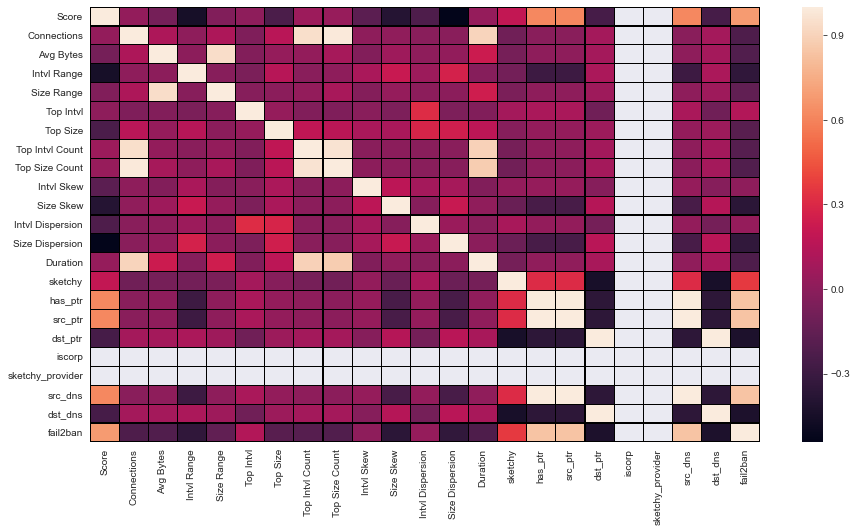

In [314]:
fig= plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), linewidths=.1, linecolor='black')

### adding viz and stats

What are the most prevalent AS Numbers?

<AxesSubplot:>

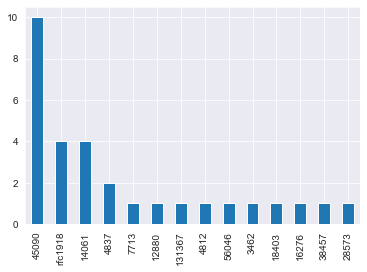

In [36]:
df['asn'][:30].value_counts().plot(kind='bar')

Where are they coming from?

<AxesSubplot:>

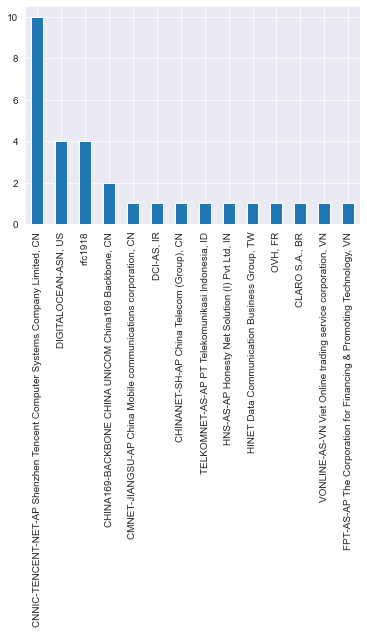

In [37]:
df['asn_desc'][:30].value_counts().plot(kind='bar')

What countries account for the most traffic?

<AxesSubplot:>

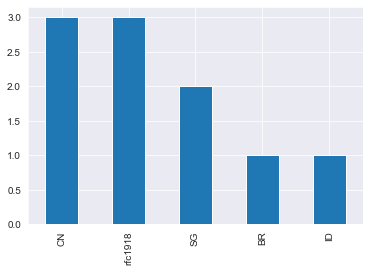

In [38]:
df['asn_country'][:10].value_counts().plot(kind='bar')

Is there a correlation between average bytes and number of connections?

<AxesSubplot:>

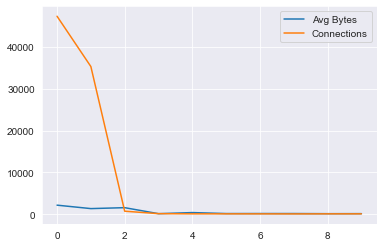

In [39]:
df[['Avg Bytes','Connections']][:10].plot()

**whats the relative occurrance of high beacon traffic?**

How about the occurrange of high beaconish traffic?

<AxesSubplot:>

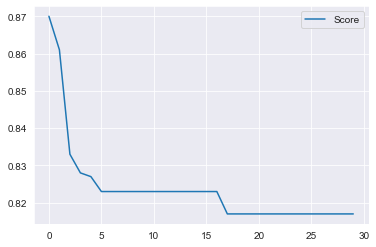

In [40]:
df[['Score']][:30].plot(y='Score')

<AxesSubplot:xlabel='Score'>

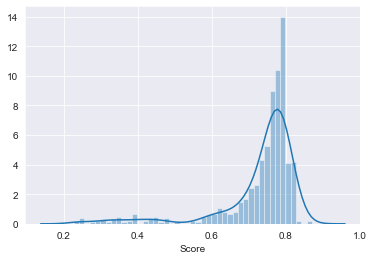

In [41]:
sns.distplot(df['Score'])

**how about long duration**

<AxesSubplot:xlabel='Duration'>

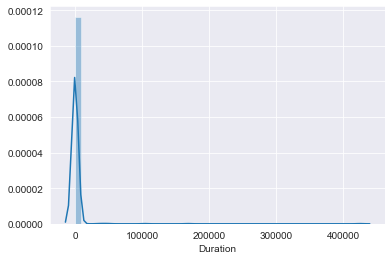

In [42]:
sns.distplot(df['Duration'])

#### how about services?


<AxesSubplot:>

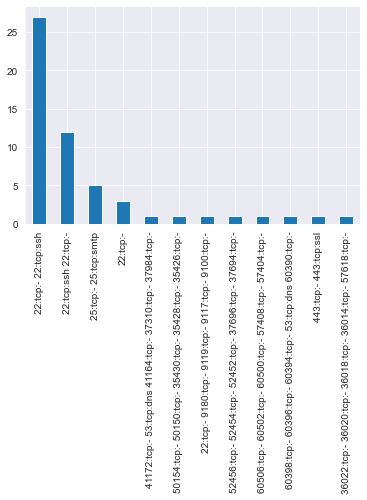

In [325]:
# The highest hits is fail2ban attempting to quash traffic, so we'll remove the ICMP entries
df[~df['Port:Protocol:Service'].str.contains('icmp')]['Port:Protocol:Service'].value_counts().plot(kind='bar')

### High Beaconish Originators

In [44]:
df[(df['Score'] >.80)][3:]['asn_desc']

3                                  DIGITALOCEAN-ASN, US
4                                        CLARO S.A., BR
5     CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
6     CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
7                                  DIGITALOCEAN-ASN, US
                            ...                        
78    CHINA169-BJ China Unicom Beijing Province Netw...
79    TENCENT-NET-AP-CN Tencent Building, Kejizhongy...
80    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
81    CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...
82    AIRTELBROADBAND-AS-AP Bharti Airtel Ltd., Tele...
Name: asn_desc, Length: 80, dtype: object

In [45]:
df['asn_country'].value_counts()

CN         336
US          75
rfc1918     54
BR          26
KR          25
IN          20
CA          17
VN          16
ID          14
SG          13
AR          13
FR          11
GB          10
CO           6
JP           5
TH           5
MY           5
RU           5
TW           5
BD           4
IR           4
TR           3
HK           3
CL           3
PK           3
EC           2
MX           2
LT           2
AE           2
PH           2
CR           2
SC           2
ZA           2
ZW           1
MU           1
JM           1
MA           1
UG           1
IT           1
BG           1
BO           1
BF           1
KZ           1
UZ           1
LA           1
PY           1
ES           1
UY           1
HR           1
FJ           1
VE           1
Name: asn_country, dtype: int64

In [46]:
# highest traffic country entries
df[df['asn_country'] =='CN']

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
5,0.823,10.4.86.55,62.234.15.136,92,163.0,185,2224,89,88,13,...,0,10.4.86.55->62.234.15.136,3:icmp:-,177.767,mainhost,62.234.15.136,62.234.0.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
6,0.823,10.4.86.55,106.54.112.173,89,169.0,268,2472,87,88,15,...,0,10.4.86.55->106.54.112.173,3:icmp:-,259.984,mainhost,106.54.112.173,106.54.64.0/18,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
9,0.823,10.4.86.55,122.51.147.181,93,145.0,155,2064,74,88,16,...,0,10.4.86.55->122.51.147.181,3:icmp:-,154.728,mainhost,122.51.147.181,122.51.128.0/18,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
12,0.823,10.4.86.55,119.45.199.173,39,168.0,255,2076,230,88,8,...,0,10.4.86.55->119.45.199.173,3:icmp:-,116.138,mainhost,119.45.199.173,119.45.192.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
13,0.823,10.4.86.55,49.234.67.158,30,147.0,296,1772,285,88,4,...,0,10.4.86.55->49.234.67.158,3:icmp:-,118.678,mainhost,49.234.67.158,49.234.64.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,0.442,10.4.86.55,222.186.31.166,76,469.0,146121,2388,980,264,2,...,88,10.4.86.55->222.186.31.166,3:icmp:-,116.738,mainhost,222.186.31.166,222.186.31.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
678,0.441,10.4.86.55,222.186.30.57,88,367.0,112922,2512,675,264,1,...,88,10.4.86.55->222.186.30.57,3:icmp:-,168.555,mainhost,222.186.30.57,222.186.30.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
679,0.432,10.4.86.55,222.186.31.83,72,384.0,103369,2516,1089,264,2,...,88,10.4.86.55->222.186.31.83,3:icmp:-,115.943,mainhost,222.186.31.83,222.186.31.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
680,0.432,10.4.86.55,218.92.0.204,185,3258.0,2026,14080,408,528,4,...,1408,10.4.86.55->218.92.0.204,3:icmp:-,2009.650,mainhost,218.92.0.204,218.92.0.0/16,4134,"CHINANET-BACKBONE No.31,Jin-rong Street, CN",CN


### build a view of connections where duration value is short and beaconish is high

In [47]:
# What are the relative duration statistics?
df['Duration'].describe()

count       715.000000
mean       1309.000445
std       17764.105103
min         115.132000
25%         116.858500
50%         117.486000
75%         139.343000
max      425655.000000
Name: Duration, dtype: float64

In [48]:
# What is the relative score distribution?
df['Score'].describe()

count    715.000000
mean       0.729592
std        0.110882
min        0.227000
25%        0.723000
50%        0.766000
75%        0.788000
max        0.870000
Name: Score, dtype: float64

In [49]:
# looking at raw duration length values
df['Duration'].sort_values()

648       115.132
712       115.144
498       115.191
362       115.191
520       115.194
          ...    
615     43213.400
691     50334.100
609    104601.000
1      169166.000
0      425655.000
Name: Duration, Length: 715, dtype: float64

**Start drilling down**

In [50]:
# 
df['Duration'].mean()

1309.0004447552446

In [51]:
# Show only durations below the mean
df[df['Duration'] < df['Duration'].mean()]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
3,0.828,10.4.86.55,139.59.38.252,141,133.0,138,2120,65,88,30,...,0,10.4.86.55->139.59.38.252,3:icmp:-,133.375,mainhost,139.59.38.252,139.59.32.0/20,14061,"DIGITALOCEAN-ASN, US",SG
4,0.827,10.4.86.55,189.62.69.106,94,397.0,44573,1856,76,352,34,...,0,10.4.86.55->189.62.69.106,3:icmp:-,161.082,mainhost,bd3e456a.virtua.com.br,189.62.0.0/16,28573,"CLARO S.A., BR",BR
5,0.823,10.4.86.55,62.234.15.136,92,163.0,185,2224,89,88,13,...,0,10.4.86.55->62.234.15.136,3:icmp:-,177.767,mainhost,62.234.15.136,62.234.0.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
6,0.823,10.4.86.55,106.54.112.173,89,169.0,268,2472,87,88,15,...,0,10.4.86.55->106.54.112.173,3:icmp:-,259.984,mainhost,106.54.112.173,106.54.64.0/18,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
7,0.823,10.4.86.55,139.59.70.186,77,167.0,156,2032,123,88,10,...,0,10.4.86.55->139.59.70.186,3:icmp:-,139.581,mainhost,139.59.70.186,139.59.64.0/20,14061,"DIGITALOCEAN-ASN, US",SG
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,0.247,146.20.191.250,10.4.86.55,42,2365.0,1155104,22326,1,867,9,...,295,146.20.191.250->10.4.86.55,25:tcp:- 25:tcp:smtp,139.105,m250.email.mailgun.net,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
711,0.246,69.72.43.210,10.4.86.55,33,7852.0,1040164,92273,1,864,4,...,56,69.72.43.210->10.4.86.55,25:tcp:- 25:tcp:smtp,160.405,m43-210.mailgun.net,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
712,0.242,222.186.180.8,10.4.86.55,792,539.0,57496,2891,120,0,125,...,40,222.186.180.8->10.4.86.55,22:tcp:- 22:tcp:ssh,115.144,222.186.180.8,mainhost,rfc1918,rfc1918,rfc1918,rfc1918
713,0.240,175.24.67.124,10.4.86.55,129,968.0,759087,1389,5,208,18,...,208,175.24.67.124->10.4.86.55,22:tcp:- 22:tcp:ssh,120.344,175.24.67.124,mainhost,rfc1918,rfc1918,rfc1918,rfc1918


**what are connections where duration is below a particular quantile?**

In [52]:
df[df['Duration'] < df['Duration'].quantile(.2)]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
12,0.823,10.4.86.55,119.45.199.173,39,168.0,255,2076,230,88,8,...,0,10.4.86.55->119.45.199.173,3:icmp:-,116.138,mainhost,119.45.199.173,119.45.192.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
16,0.823,10.4.86.55,45.55.242.212,47,128.0,211,1904,182,88,7,...,0,10.4.86.55->45.55.242.212,3:icmp:-,116.385,mainhost,45.55.242.212,45.55.192.0/18,14061,"DIGITALOCEAN-ASN, US",US
26,0.817,10.4.86.55,120.88.46.226,38,241.0,257,1944,236,88,5,...,0,10.4.86.55->120.88.46.226,3:icmp:-,116.170,mainhost,120-88-46-226.snat21.hns.net.in,120.88.46.0/24,38457,"HNS-AS-AP Honesty Net Solution (I) Pvt Ltd, IN",IN
28,0.817,10.4.86.55,49.235.69.80,34,239.0,506,1788,243,88,4,...,0,10.4.86.55->49.235.69.80,3:icmp:-,115.211,mainhost,49.235.69.80,49.235.64.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
31,0.817,10.4.86.55,119.45.137.52,25,291.0,581,1680,341,88,3,...,0,10.4.86.55->119.45.137.52,3:icmp:-,116.371,mainhost,119.45.137.52,119.45.128.0/20,45090,CNNIC-TENCENT-NET-AP Shenzhen Tencent Computer...,CN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.500,10.4.86.55,117.211.192.70,61,302.0,301,1964,180,68,26,...,284,10.4.86.55->117.211.192.70,3:icmp:-,116.419,mainhost,117.211.192.70,117.211.192.0/20,9829,"BSNL-NIB National Internet Backbone, IN",IN
671,0.473,10.4.86.55,222.186.42.155,82,344.0,116591,2128,1291,264,2,...,88,10.4.86.55->222.186.42.155,3:icmp:-,116.373,mainhost,222.186.42.155,222.186.42.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
679,0.432,10.4.86.55,222.186.31.83,72,384.0,103369,2516,1089,264,2,...,88,10.4.86.55->222.186.31.83,3:icmp:-,115.943,mainhost,222.186.31.83,222.186.31.0/24,23650,CHINANET-JIANGSU-PROVINCE-IDC AS Number for CH...,CN
694,0.345,189.62.69.106,10.4.86.55,198,167.0,44634,1569,7,60,89,...,120,189.62.69.106->10.4.86.55,22:tcp:- 22:tcp:ssh,115.282,bd3e456a.virtua.com.br,mainhost,rfc1918,rfc1918,rfc1918,rfc1918


**connections where duration value is short and beaconish is high**

- only get low duration connections which exhibit above %75 beaconism 

In this case, there a bunch of ICMP messages originating from my host heading to (mostly) China. If fail2ban wasn't running this might be cause for further investigation, but fail2ban sends ICMP type 3 packets to an originator when it gets jailed. We're catching this upstream in the fail2ban column. 

In [299]:
print(len(df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]))
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)][:3]

84


,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns,fail2ban
12,0.823,10.4.86.55,119.45.199.173,39,168.0,255,2076,230,88,8,...,CN,True,True,True,False,False,False,True,False,True
16,0.823,10.4.86.55,45.55.242.212,47,128.0,211,1904,182,88,7,...,US,False,True,True,False,False,False,True,False,True
26,0.817,10.4.86.55,120.88.46.226,38,241.0,257,1944,236,88,5,...,IN,True,True,True,True,False,False,True,True,True


**if anything is left that's not fail2ban there is something to dig further into**

In [326]:
# if anything is left that's not fail2ban there is something to dig further into
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)&(~df['fail2ban'])]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns,fail2ban
260,0.784,223.247.137.208,10.4.86.55,36,347.0,503,1633,308,60,6,...,rfc1918,False,False,False,True,False,False,False,True,False


In [54]:
# is anything not originating from my ip?
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)]['Source IP'].unique()

array(['10.4.86.55', '223.247.137.208'], dtype=object)

In [307]:
# look at only non-fail2ban items where Duration is in the upper quantile, Score is greater than .75 and originates from my server
# nothing here - so it looks like beaconish activity here is fail2ban related (handled by )
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)& (~df['fail2ban']) &(df['Source IP'].str.contains('10.4.86.55'))]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns,fail2ban


In [56]:
df[(df['Duration'] < df['Duration'].quantile(.2)) & (df['Score'] > .75)&(df['Source IP'] != '10.4.86.55')]

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,Size Dispersion,ConnString,Port:Protocol:Service,Duration,Source Name,Destination Name,asncidr,asn,asn_desc,asn_country
260,0.784,223.247.137.208,10.4.86.55,36,347.0,503,1633,308,60,6,...,0,223.247.137.208->10.4.86.55,22:tcp:- 22:tcp:ssh,115.725,223.247.137.208,mainhost,rfc1918,rfc1918,rfc1918,rfc1918


In [57]:
def showline(ipaddress):
    return df[df['Source IP'] == ipaddress]

In [329]:
showline('223.247.137.208')

,Score,Source IP,Destination IP,Connections,Avg Bytes,Intvl Range,Size Range,Top Intvl,Top Size,Top Intvl Count,...,asn_country,sketchy,has_ptr,src_ptr,dst_ptr,iscorp,sketchy_provider,src_dns,dst_dns,fail2ban
260,0.784,223.247.137.208,10.4.86.55,36,347.0,503,1633,308,60,6,...,rfc1918,False,False,False,True,False,False,False,True,False


In [308]:
# where are ssh connections coming/going?
# everything appears to be incoming, so we aren't launching any attacks
df[(df['Port:Protocol:Service'].str.contains('ssh')) & (df['Source IP'] != "10.4.86.55")]['ConnString'].unique()

array(['193.112.19.133->10.4.86.55', '223.247.137.208->10.4.86.55',
       '222.186.42.7->10.4.86.55', '222.186.42.57->10.4.86.55',
       '222.186.42.213->10.4.86.55', '123.206.65.38->10.4.86.55',
       '118.89.245.202->10.4.86.55', '106.52.152.237->10.4.86.55',
       '106.53.114.90->10.4.86.55', '122.51.22.134->10.4.86.55',
       '49.233.32.245->10.4.86.55', '129.28.27.25->10.4.86.55',
       '122.194.229.59->10.4.86.55', '61.177.172.107->10.4.86.55',
       '61.177.172.128->10.4.86.55', '218.92.0.172->10.4.86.55',
       '129.204.125.51->10.4.86.55', '117.211.192.70->10.4.86.55',
       '118.24.117.134->10.4.86.55', '129.204.100.10->10.4.86.55',
       '49.232.191.178->10.4.86.55', '112.85.42.174->10.4.86.55',
       '94.191.62.195->10.4.86.55', '194.180.224.130->10.4.86.55',
       '189.62.69.106->10.4.86.55', '139.186.68.53->10.4.86.55',
       '85.209.0.253->10.4.86.55', '122.51.221.184->10.4.86.55',
       '119.45.205.97->10.4.86.55', '122.51.10.222->10.4.86.55',
       '119.